In [1]:
%matplotlib notebook
from matplotlib.lines import Line2D

In [2]:
#imports
from tqdm import tqdm
import time
import numpy as np
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import ensemble
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import preprocessing
import matplotlib.pylab as plt
import shutil
from matplotlib.lines import Line2D
import pandas
from sklearn.model_selection import train_test_split
from xgboost import XGBRFRegressor
import xgboost as xgb
import scipy
from applicability_domain import ApplicabilityDomainDetector
from sklearn.preprocessing import FunctionTransformer


%matplotlib notebook

/home/ealonso/anaconda3/envs/rdkitenv/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
#Load Data
family = 'all_hl'
all_data = json.load(open('./all_data.json'))
X = np.array(all_data[family]['reaction_feature_lists'])
y = np.array(all_data[family]['Ea_values'])

In [4]:
#Test/Train/Validation Split
#%matplotlib notebook
training_x = []
training_y = []
test_x = []
test_y = []

kf = KFold(n_splits=5, shuffle=True, random_state = 9)
kf.get_n_splits(X)

include_automatic_domain_applicability = False

params_1 = {
    'booster': 'gbtree',
    'max_depth': 200, 
    'learning_rate': 0.05,
    'sample_type': 'weighted',
    'normalize_type': 'forest',
    'objective': 'reg:squarederror',
#     'feature_selector':"greedy",
#     'max_leaves ': 100,
#     'rate_drop': 0.1,
    'n_estimators': 1000}
results_json = {}
count = 0
MAE_test = []
MAE_train = []
R2_train = []
R2_test = []
for train_index, test_index in kf.split(X):
    count+=1
    if count>1:
        break
    print('trainint start:',count)
    #     print("TRAIN:", train_index, "TEST:", test_index)
#     temp_test_index = []
#     included_xvals = []
#     for i in test_index:
#         test_X_vector = str(X[i].tolist())
#         if len(ynew[test_X_vector])<2:
#             temp_test_index.append(i)
#         elif not in included_xvals:
#             included_xvals.append()
#             temp_test_index.append(i)
#     test_index=np.array(temp_test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    if include_automatic_domain_applicability:
#         DummyScaler = FunctionTransformer(lambda x: x)
        ad = ApplicabilityDomainDetector(k = 5, alpha = 0.95)
        xy_all_together = np.hstack((X_train,y_train))
        xy_test_all_together = np.hstack(([X_test,y_test]))
        ad.fit(xy_all_together)
        X_test_inlier = xy_test_all_together#ad.transform(xy_test_all_together)
        X_test=X_test_inlier[:,0:-2]
        y_test=X_test_inlier[:,-1]
    
    
    
    d_train = xgb.DMatrix(X_train, y_train)
    d_test = xgb.DMatrix(X_test, y_test)
    xgb_clf = xgb.train(params_1, d_train,num_boost_round=200)
    
    preds = xgb_clf.predict(d_test)
    preds_2 = xgb_clf.predict(d_train)
    
    MAE_test.append(mean_absolute_error(y_test, preds)/(4184)) 
    MAE_train.append(mean_absolute_error(y_train, preds_2)/4184) 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(preds_2, y_train)
    R2_train.append(r_value) 
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(preds, y_test)
    R2_test.append(r_value) 

results_json.update({'xgboost':{
                     "cv scores":R2_train,
                     "cv scores mean":np.average(R2_train),
                     "test set score":np.average(R2_test),
                     "train MAE":MAE_train,
                     "test MAE": MAE_test}})
print(json.dumps(results_json["xgboost"],indent = 2))
print(np.average(results_json["xgboost"]['test MAE']))
print(np.std(results_json["xgboost"]['test MAE']))

trainint start: 1
[11:58:26] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "n_estimators", "normalize_type", "sample_type" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


{
  "cv scores": [
    0.9923398889502193
  ],
  "cv scores mean": 0.9923398889502193,
  "test set score": 0.943321873409141,
  "train MAE": [
    0.620397926819015
  ],
  "test MAE": [
    2.353942175863507
  ]
}
2.353942175863507
0.0


<IPython.core.display.Javascript object>


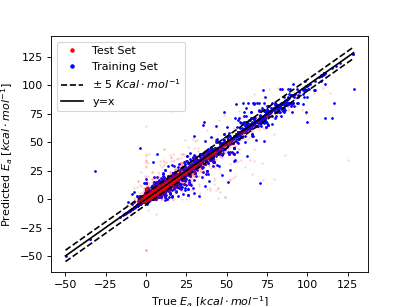

In [5]:
#Test Parity plot
preds = xgb_clf.predict(d_test)
preds_2 = xgb_clf.predict(d_train)

clf = xgb_clf
Xplot = np.array(preds)
Yplot = np.array(y_test)
p = np.polyfit(Xplot,Yplot,1)
Xplot = np.polyval(p=p,x=Xplot)
scale = (1/4184)
minx,maxx = (min(np.array(y_train)),max(np.array(y_train)))
print()
min_max_linspace = np.linspace(minx*scale,maxx*scale)

fig,ax = plt.subplots()
ax.scatter(np.array(y_train)*scale,preds_2*scale,c='b', s = 2,alpha=1)

ax.scatter(np.array(Yplot)*scale,np.array(Xplot)*scale,c='r', s = 2,alpha=0.1)
ax.plot(min_max_linspace,min_max_linspace,"k")
plt.plot(np.linspace(min(np.array(y_train)*scale),max(np.array(y_train)*scale),3),
        np.linspace(min(np.array(y_train)*scale),max(np.array(y_train)*scale),3)+5,"k--")
plt.plot(np.linspace(min(np.array(y_train)*scale),max(np.array(y_train)*scale),3),
        np.linspace(min(np.array(y_train)*scale),max(np.array(y_train)*scale),3)-5,"k--")

plt.ylabel('Predicted $E_a$ $[kcal \cdot mol^{-1}]$')
plt.xlabel('True $E_a$ $[kcal \cdot mol^{-1}]$')

#legend
colors = ['red', 'blue','black','black']

lines = [Line2D([0], [0], color='r', linestyle='None',marker='.'),
         Line2D([0], [0], color='b', linestyle='None',marker='.'),
         Line2D([0], [0], color='k', linestyle='--'),
         Line2D([0], [0], color='k', linestyle='-')]
labels = ['Test Set', 'Training Set', '$\pm$ 5 $K cal\cdot mol ^{-1}$',"y=x"]
plt.xlim
plt.legend(lines, labels)
plt.show()

# print(clf.score(x_test,y_test), "test")
# print(clf.score(x_train,y_train), 'train')

#len(np.unique(np.array([str(i) for i in X])))
# fig.savefig(fname="test_train_set_all_PP.png")

In [6]:
print(mean_absolute_error(y_test, preds)/4184)
# MAE_train.append(mean_squared_error(y_train, preds_2)/4184**2) 

2.353942175863507


<IPython.core.display.Javascript object>


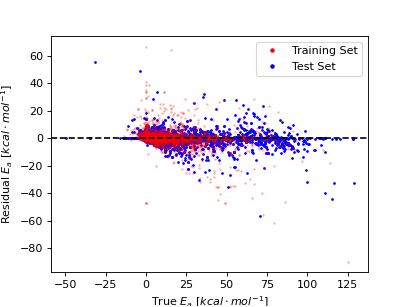

0.9390009606147934 fraction of predictions within chemical accuracy


In [7]:
#Parity plot Residual
Xplot = np.array(preds) - np.array(y_test)
Yplot = np.array(y_test)
p = np.polyfit(Xplot,Yplot,1)
scale = (1/4184)

fig,ax = plt.subplots()
ax.scatter(np.array(y_train)*scale,
         preds_2*scale - np.array(y_train)*scale,
         c='b', s = 2)
ax.scatter(np.array(Yplot)*scale,np.array(Xplot)*scale,c='r', s = 2,alpha=0.2)

plt.ylabel('Residual $E_a$ $[kcal \cdot mol^{-1}]$')
plt.xlabel('True $E_a$ $[kcal \cdot mol^{-1}]$')

lines = [Line2D([0], [0], color='r', linestyle='None',marker='.'),
         Line2D([0], [0], color='b', linestyle='None',marker='.')]
labels = ['Training Set', 'Test Set']
x_lims = plt.xlim()
plt.hlines(0,x_lims[0], x_lims[1], colors='k', linestyle='--',zorder=np.inf)
plt.xlim(x_lims)
plt.legend(lines, labels)
fig.savefig(fname="residual_test_train_set.png")
print(np.sum(Xplot<20920)/len(Xplot),'fraction of predictions within chemical accuracy')

<IPython.core.display.Javascript object>


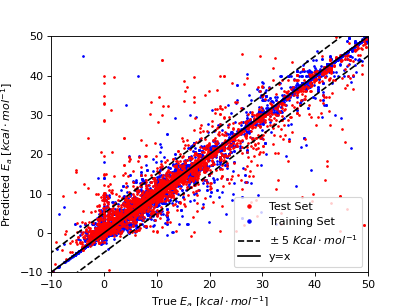

In [8]:
# Parity plot
clf = xgb_clf
Xplot = np.array(preds)
Yplot = np.array(y_test)
p = np.polyfit(Xplot,Yplot,1)
Xplot = np.polyval(p=p,x=Xplot)
scale = (1/4184)
minx,maxx = (min(np.array(y_train)),max(np.array(y_train)))
print()
min_max_linspace = np.linspace(minx*scale,maxx*scale)

fig,ax = plt.subplots()
ax.scatter(np.array(y_train)*scale,preds_2*scale,c='b', s = 2,alpha=1)

ax.scatter(np.array(Yplot)*scale,np.array(Xplot)*scale,c='r', s = 2,alpha=0.99)
ax.plot(min_max_linspace,min_max_linspace,"k")
plt.plot(np.linspace(min(np.array(y_train)*scale),max(np.array(y_train)*scale),3),
        np.linspace(min(np.array(y_train)*scale),max(np.array(y_train)*scale),3)+5,"k--")
plt.plot(np.linspace(min(np.array(y_train)*scale),max(np.array(y_train)*scale),3),
        np.linspace(min(np.array(y_train)*scale),max(np.array(y_train)*scale),3)-5,"k--")

plt.ylabel('Predicted $E_a$ $[kcal \cdot mol^{-1}]$')
plt.xlabel('True $E_a$ $[kcal \cdot mol^{-1}]$')

#legend
colors = ['red', 'blue','black','black']

lines = [Line2D([0], [0], color='r', linestyle='None',marker='.'),
         Line2D([0], [0], color='b', linestyle='None',marker='.'),
         Line2D([0], [0], color='k', linestyle='--'),
         Line2D([0], [0], color='k', linestyle='-')]
labels = ['Test Set', 'Training Set', '$\pm$ 5 $K cal\cdot mol ^{-1}$',"y=x"]
plt.xlim((-10,50))
plt.ylim((-10,50))
plt.legend(lines, labels)
plt.show()
fig.savefig(fname="test_train_set_all_PP.png")

<IPython.core.display.Javascript object>


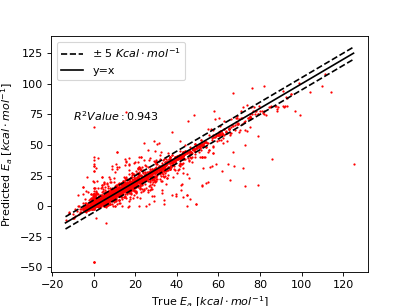

In [9]:
#Validation Parity plot
Xplot = preds
Yplot = np.array(y_test)
p = np.polyfit(Xplot,Yplot,1)
Xplot = np.polyval(p=p,x=Xplot)
scale = (1/4.184)

fig,ax = plt.subplots()

#plt.plot( np.array(y_train)*scale*1e-3,clf.predict(x_train)*scale*1e-3,'b.', markersize = 2)
plt.plot( np.array(Yplot)*scale*1e-3,np.array(Xplot)*scale*1e-3,'r.', markersize = 2)

plt.plot(np.linspace(min(Yplot*scale*1e-3),max(Yplot*scale*1e-3),3),
         np.linspace(min(Yplot*scale*1e-3),max(Yplot*scale*1e-3),3),'k-')
plt.plot(np.linspace(min(Yplot*scale*1e-3),max(Yplot*scale*1e-3),3),
         np.linspace(min(Yplot*scale*1e-3),max(Yplot*scale*1e-3),3)+5,'k--')
plt.plot(np.linspace(min(Yplot*scale*1e-3),max(Yplot*scale*1e-3),3),
         np.linspace(min(Yplot*scale*1e-3),max(Yplot*scale*1e-3),3)-5,'k--')

plt.ylabel('Predicted $E_a$ $[kcal \cdot mol^{-1}]$')
plt.xlabel('True $E_a$ $[kcal \cdot mol^{-1}]$')
plt.text(-10, 70, "$R^2 Value :%.3f$"%r_value)
lines = [Line2D([0], [0], color='k', linestyle='--'),
         Line2D([0], [0], color='k', linestyle='-')]
labels = ['$\pm$ 5 $K cal\cdot mol ^{-1}$',"y=x"]
plt.legend(lines, labels)
fig.savefig(fname="PP_validation_set.png",dpi = 300)

<IPython.core.display.Javascript object>


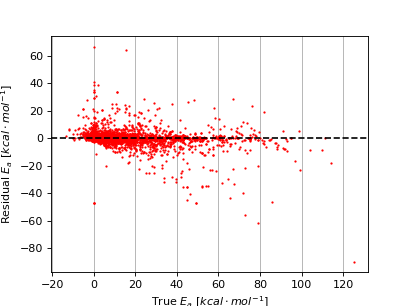

In [10]:
#Parity plot Residual Validation
Xplot = np.array(preds)- np.array(y_test)
Yplot = np.array(y_test)
p = np.polyfit(Xplot,Yplot,1)
scale = (1/4.184)*1e-3

fig,ax = plt.subplots()
plt.plot(Yplot*scale,Xplot*scale,'r.', markersize = 2)

x_lims = plt.xlim()
plt.hlines(0,x_lims[0], x_lims[1], colors='k', linestyle='--',zorder=np.inf)
plt.xlim(x_lims)

plt.ylabel('Residual $E_a$ $[kcal \cdot mol^{-1}]$')
plt.xlabel('True $E_a$ $[kcal \cdot mol^{-1}]$')
fig.savefig(fname="residual_validation_set.png")

In [11]:
#feature importance values
feat_imp_dict = xgb_clf.get_score(importance_type='weight')
feat_imp = []
feat_num = []
for i in feat_imp_dict.keys():
    feat_imp.append(feat_imp_dict[i])
    feat_num.append(i)
full_sum = np.sum(feat_imp)
feat_imp = np.array(feat_imp)/np.sum(feat_imp)

111


<IPython.core.display.Javascript object>


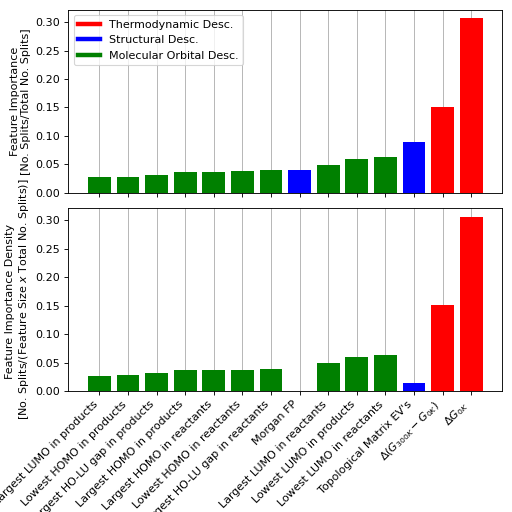

No handles with labels found to put in legend.


In [12]:
#Feature Importance Density
indices_explained = all_data[family]['description_of_feature_indices']
labels = feat_num
label_names = []
for i in labels:
    label_names.append(indices_explained[i.replace('f','')])
labels = np.unique(label_names).tolist()
sums = [0 for i in labels]
feature_sizes = [0 for i in labels]



for j,i in enumerate(indices_explained):
    try:
        name = 'f'+str(j)
        index_sum = labels.index(indices_explained[str(j)])
        sums[index_sum]+=feat_imp_dict[name]/full_sum
        feature_sizes[index_sum]+=1
    except:
        feature_sizes[index_sum]+=1
print(len(feat_imp_dict))
for i in labels.copy():
    ind = labels.index(i)
    if sums[ind]<0.0:
        labels.pop(ind)
        sums.pop(ind)
        feature_sizes.pop(ind)

labels = [i for i in labels]
colorlist = ['g']*len(labels)
feature_dens = [sums[i]/feature_sizes[i] for i in range(len(labels))]

label_importance_tuple = [(sums[i],labels[i],feature_dens[i]) for i in \
                          range(len(labels))]
label_importance_tuple = sorted(label_importance_tuple, key=lambda x:x[0])


labels = [i[1] for i in label_importance_tuple]
feature_dens = [i[2] for i in label_importance_tuple]
colorlist[labels.index("enthalpy")] = 'r'
colorlist[labels.index("entropy")] = 'r'
colorlist[labels.index("morgan")] = 'b'
colorlist[labels.index("topo")] = 'b'
try:
#     colorlist[labels.index("enthalpy")] = 'r'
    labels[labels.index("enthalpy")] = "$\Delta G_{0K}$"
#     colorlist[labels.index("entropy")] = 'r'
    labels[labels.index("entropy")] = "$\Delta (G_{300K} - G_{0K})$"
#     colorlist[labels.index("morgan")] = 'b'
    labels[labels.index("morgan")] = "Morgan FP"
#     colorlist[labels.index("topo")] = 'b'
    labels[labels.index("topo")] = "Topological Matrix EV's"
    
    # labels[labels.index("hom-lum")] = "$\Delta (LUMO-HOMO)$"
    # labels[labels.index("min_lumo_reactants")] = "Max LUMO in reactants"
    # labels[labels.index("min_lumo_reactants")] = "Max LUMO in reactants"
    labels[labels.index("max_lumo_reactants")] = "Largest LUMO in reactants"
    labels[labels.index("min_lumo_reactants")] = "Lowest LUMO in reactants"
    labels[labels.index("max_lumo_products")] = "Largest LUMO in products"
    labels[labels.index("min_lumo_products")] = "Lowest LUMO in products"

    labels[labels.index("max_homo_reactants")] = "Largest HOMO in reactants"
    labels[labels.index("min_homo_reactants")] = "Lowest HOMO in reactants"
    labels[labels.index("max_homo_products")] = "Largest HOMO in products"
    labels[labels.index("min_homo_products")] = "Lowest HOMO in products"

    labels[labels.index("max_h-l_products")] = "Largest HO-LU gap in products"
    labels[labels.index("max_h-l_reactants")] = "Largest HO-LU gap in reactants"
except ValueError:
    labels = [i for i in labels]
    print("labels might be wrong")

sums =  [i[0] for i in label_importance_tuple]

plt.grid(axis='x')
fig, axs = plt.subplots(2)
fig.set_figheight(8)
fig.set_figwidth(8)


axs[0].bar(range(len(labels)), sums, color=colorlist,zorder=3)
axs[0].set_xticks(range(len(labels)))
axs[0].set_xticklabels(["" for i in labels])
axs[0].set_ylabel("Feature Importance\n[No. Splits/Total No. Splits]")
axs[0].xaxis.grid()
axs[0].legend()

axs[1].bar(range(len(labels)), feature_dens,color=colorlist,zorder=3)
axs[1].set_xticks(range(len(labels)))
axs[1].xaxis.grid(zorder=0)
axs[1].set_xticklabels(labels,rotation=45,ha='right')
axs[1].set_ylabel("Feature Importance Density \n[No. Splits/(Feature Size $x$ Total No. Splits)]")


custom_lines = [Line2D([0], [0], color='r', lw=4),
                Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='g', lw=4)]

axs[0].legend(custom_lines, ['Thermodynamic Desc.', 'Structural Desc.',
                             'Molecular Orbital Desc.'],loc='upper left',ncol=1)

fig.tight_layout()
# fig.savefig(fname="Feature Importance.png")

In [13]:
xy_all_together = np.c_[X_train,y_train]
# xy_test_all_together = np.c_[X_test,y_test]

In [14]:
xy_all_together.shape

(16652, 119)